In [29]:
import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display

import utils
plt.rcParams['figure.figsize'] = (13, 5)
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif



## CREO DBMERGE

In [30]:
features = utils.load('data/fma_metadata/features.csv')

features.shape

(106574, 518)

In [31]:
tracks = utils.load('data/fma_metadata/tracks.csv')

In [32]:
tracks=tracks[[('set','subset'),('track','genre_top')]]

In [33]:
mediumSet=tracks.loc[tracks[('set','subset')] != 'large']

In [34]:
mediumSet=pd.concat([mediumSet], axis=1, keys=['metadata']).swaplevel(1, 1, 1)
mediumSet.head()

metadata          
              set     track
           subset genre_top
track_id                   
2           small   Hip-Hop
3          medium   Hip-Hop
5           small   Hip-Hop
10          small       Pop
134        medium   Hip-Hop

In [35]:
mediumSet=mediumSet.rename_axis(columns=["feature","statistics","number"])

mediumSet.head()

feature    metadata          
statistics      set     track
number       subset genre_top
track_id                     
2             small   Hip-Hop
3            medium   Hip-Hop
5             small   Hip-Hop
10            small       Pop
134          medium   Hip-Hop

In [36]:
DBMERGE= pd.merge(mediumSet, features, left_index=True, right_index=True)
DBMERGE.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 2 to 155314
Columns: 520 entries, ('metadata', 'set', 'subset') to ('zcr', 'std', '01')
dtypes: category(2), float64(518)
memory usage: 99.0 MB


In [37]:
DBMERGE.to_csv('data/fma_metadata/DBMERGEfeatures.csv', index = True)

## SELEZIONO 20 ATTRIBUTI

In [38]:
# Create correlation matrix
corr_matrix = DBMERGE.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.50
to_drop = [column for column in upper.columns if any(upper[column] > 0.60)]

# Drop features 
DBMERGE.drop(to_drop, axis=1, inplace=True)

In [39]:
DBMERGE.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 2 to 155314
Columns: 193 entries, ('metadata', 'set', 'subset') to ('zcr', 'kurtosis', '01')
dtypes: category(2), float64(191)
memory usage: 36.7 MB


In [40]:

# creating instance of labelencoder
le = LabelEncoder()
DBMERGE[('metadata','track','genre_top_Cat')] = le.fit_transform(DBMERGE[('metadata','track','genre_top')])

In [41]:
DBMERGE.head()

feature    metadata           chroma_cens                                \
statistics      set     track    kurtosis                                 
number       subset genre_top          01        02        03        04   
track_id                                                                  
2             small   Hip-Hop    7.180653  5.230309  0.249321  1.347620   
3            medium   Hip-Hop    1.888963  0.760539  0.345297  2.295201   
5             small   Hip-Hop    0.527563 -0.077654 -0.279610  0.685883   
10            small       Pop    3.702245 -0.291193  2.196742 -0.234449   
134          medium   Hip-Hop    0.918445  0.674147  0.577818  1.281117   

feature                                             ...   tonnetz            \
statistics                                          ...       min      skew   
number            05        06        07        08  ...        06        01   
track_id                                            ...                       
2           1.482478  0.531371  1.481593  2.691455  ... -0.089286  0.752462   
3           1.654031  0.067592  1.366848  1.054094  ... -0.055667  0.265541   
5           1.937570  0.880839 -0.923192 -0.927232  ... -0.146136  1.212025   
10          1.367364  0.998411  1.770694  1.604566  ... -0.029836 -0.135219   
134         0.933746  0.078177  1.199204 -0.175223  ... -0.053569  0.927807   

feature                                                                 \
statistics                                                         std   
number            02        03        04        05        06        01   
track_id                                                                 
2           0.262607  0.200944  0.593595 -0.177665 -1.424201  0.019809   
3          -0.131471  0.171930 -0.990710  0.574556  0.556494  0.026316   
5           0.218381 -0.419971 -0.014541 -0.199314 -0.925733  0.025550   
10         -0.275780  0.015767 -1.094873  1.164041  0.246746  0.021413   
134        -0.947771  0.143864 -0.529867  0.162188  0.063846  0.024258   

feature           zcr      metadata  
statistics   kurtosis         track  
number             01 genre_top_Cat  
track_id                             
2            5.758890             7  
3            2.824694             7  
5            6.808415             7  
10          21.434212            12  
134          4.731087             7  

[5 rows x 194 columns]

In [42]:

attributes = [col for col in DBMERGE.columns if (col != ('metadata','track','genre_top') and 
                                                  col != ('metadata','set','subset')  and
                                                 col != ('metadata','track','genre_top_Cat'))] 

X = DBMERGE[attributes].values
y = DBMERGE[('metadata','track','genre_top_Cat')]

In [43]:
sel=SelectKBest(k=20)
X_sel=sel.fit_transform(X,y)
df=DBMERGE.drop([('metadata', 'track','genre_top'),('metadata','set','subset'),('metadata','track','genre_top_Cat')], axis = 1)

feat_importance=dict(zip(df.columns,sel.scores_))
feat_importance

{('chroma_cens', 'kurtosis', '01'): 20.46156353355033,
 ('chroma_cens', 'kurtosis', '02'): 29.24141641071257,
 ('chroma_cens', 'kurtosis', '03'): 3.8934992860852766,
 ('chroma_cens', 'kurtosis', '04'): 11.560085613808157,
 ('chroma_cens', 'kurtosis', '05'): 16.728558988292857,
 ('chroma_cens', 'kurtosis', '06'): 13.98007179936684,
 ('chroma_cens', 'kurtosis', '07'): 27.069128606776765,
 ('chroma_cens', 'kurtosis', '08'): 18.294263051124336,
 ('chroma_cens', 'kurtosis', '09'): 26.265720649330657,
 ('chroma_cens', 'kurtosis', '10'): 21.40698860449529,
 ('chroma_cens', 'kurtosis', '11'): 7.846625754412348,
 ('chroma_cens', 'kurtosis', '12'): 16.808930660331498,
 ('chroma_cens', 'max', '01'): 63.69861370867771,
 ('chroma_cens', 'max', '02'): 62.49783047622246,
 ('chroma_cens', 'max', '03'): 71.55308698270295,
 ('chroma_cens', 'max', '04'): 51.42994958518961,
 ('chroma_cens', 'max', '05'): 67.21929467867332,
 ('chroma_cens', 'max', '06'): 52.64116720604791,
 ('chroma_cens', 'max', '07'): 62

In [44]:
df_ridotto=df[df.columns[sel.get_support()]]
df_ridotto

feature    chroma_stft       mfcc                                    \
statistics        mean        max                                     
number              01         01         03          04         07   
track_id                                                              
2             0.696063  28.657707  52.424423  103.289833  37.843021   
3             0.449602  29.380682  76.742714  137.245010  55.662521   
5             0.481160 -40.500740  50.373932  112.312531  29.266182   
10            0.388109  20.196968  60.412815   78.466721  21.597277   
134           0.438062 -41.723225  58.687328  125.922821  37.450359   
...                ...        ...        ...         ...        ...   
155297        0.408626   3.826046  94.208336   48.085751  26.723190   
155298        0.439034 -72.790154  81.013275  124.569000  29.571426   
155306        0.369401  -7.814734  88.024063  116.180260  29.388819   
155307        0.357939 -13.889938  62.219879   93.028778  41.311356   
155314        0.551894 -15.305521  32.737503   95.054657  25.620636   

feature                                                                \
statistics                   mean           min                         
number             11          02            02         04         05   
track_id                                                                
2           27.737400  116.696678 -1.421085e-14 -51.569004 -97.879890   
3           26.740063  120.158501 -1.851665e+01 -12.548506 -87.048355   
5           27.197964  132.215073 -6.228398e+01 -24.319845 -74.060310   
10          24.780317  157.040085  5.151435e-14 -50.578659 -45.113949   
134         36.486378  125.521309 -9.427860e-01 -90.334747 -67.671829   
...               ...         ...           ...        ...        ...   
155297      19.866936  163.954620 -1.776357e-14 -29.221125 -28.104187   
155298      38.472843  160.770218 -7.993606e-14  -7.314378 -69.236115   
155306      47.185654  177.614151  5.329071e-15 -49.451691 -70.841232   
155307      33.690544  124.228142 -5.892177e+00 -50.547176 -99.119080   
155314      34.402496  166.692734 -2.464827e-01 -55.172737 -55.477066   

feature                                                            \
statistics                 skew         std                         
number             11        04          01         02         04   
track_id                                                            
2          -49.195107  0.043292   97.809044  38.569584  20.767921   
3          -46.103527 -0.026875  111.686371  41.191982  22.025253   
5          -46.700871 -0.108640   95.049904  39.367599  24.319347   
10         -33.503983 -0.561734  102.743553  44.409843  14.013119   
134        -46.685959 -0.479446  102.779747  47.266518  36.841534   
...               ...       ...         ...        ...        ...   
155297     -19.892073  0.369148   91.869461  30.287067  12.060067   
155298     -33.599331  0.602545   94.696381  39.359367  18.604885   
155306     -25.193905  0.172813  109.087029  40.537926  28.671246   
155307     -31.271780 -0.412079   80.234474  35.382370  22.123117   
155314     -41.693249 -1.755459   64.040298  26.786989  22.369673   

feature    spectral_bandwidth spectral_contrast                        tonnetz  
statistics           kurtosis               max                  min       std  
number                     01                03         04        02        01  
track_id                                                                        
2                    3.874384         39.333603  31.513493  2.296826  0.019809  
3                    2.383340         42.141411  31.473713  0.652681  0.026316  
5                    0.895442         39.017235  33.707951  2.314010  0.025550  
10                   0.437628         45.410881  28.711344  4.415900  0.021413  
134                  0.372903         41.526760  32.224319  1.270560  0.024258  
...                       ...               ...        ...       ...     

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]),
 <a list of 20 Text major ticklabel objects>)

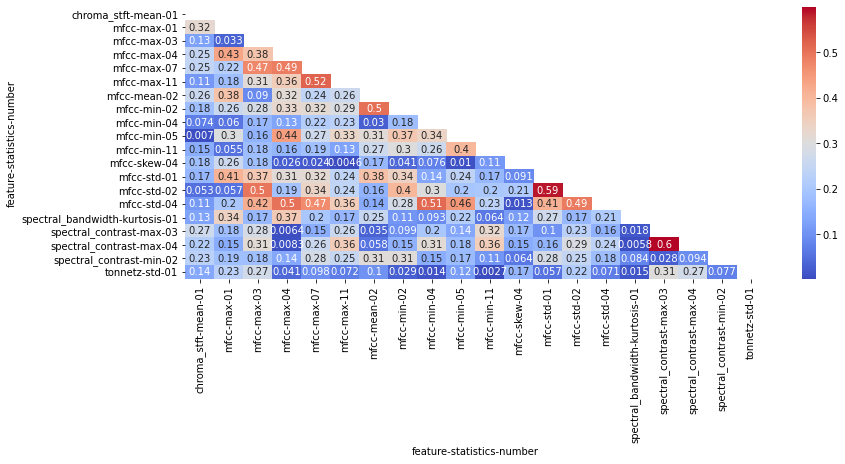

In [45]:

corr=df_ridotto.corr()
mask=np.zeros_like(corr,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True
sns.heatmap(corr.abs(),annot=True,cmap="coolwarm",mask=mask);
plt.xticks(rotation=90)

In [46]:
df_analisi=df_ridotto.copy()
df_analisi[('metadata','set','subset')]=DBMERGE[[('metadata','set','subset')]].copy() 

In [47]:
df_analisi[('metadata','track','genre_top')]=DBMERGE[('metadata','track','genre_top')].copy() 

In [48]:
df_analisi[('metadata','track','genre_top_Cat')]=y

In [49]:
df_analisi.head()

feature    chroma_stft       mfcc                                    \
statistics        mean        max                                     
number              01         01         03          04         07   
track_id                                                              
2             0.696063  28.657707  52.424423  103.289833  37.843021   
3             0.449602  29.380682  76.742714  137.245010  55.662521   
5             0.481160 -40.500740  50.373932  112.312531  29.266182   
10            0.388109  20.196968  60.412815   78.466721  21.597277   
134           0.438062 -41.723225  58.687328  125.922821  37.450359   

feature                                                                ...  \
statistics                   mean           min                        ...   
number             11          02            02         04         05  ...   
track_id                                                               ...   
2           27.737400  116.696678 -1.421085e-14 -51.569004 -97.879890  ...   
3           26.740063  120.158501 -1.851665e+01 -12.548506 -87.048355  ...   
5           27.197964  132.215073 -6.228398e+01 -24.319845 -74.060310  ...   
10          24.780317  157.040085  5.151435e-14 -50.578659 -45.113949  ...   
134         36.486378  125.521309 -9.427860e-01 -90.334747 -67.671829  ...   

feature                          spectral_bandwidth spectral_contrast  \
statistics        std                      kurtosis               max   
number             02         04                 01                03   
track_id                                                                
2           38.569584  20.767921           3.874384         39.333603   
3           41.191982  22.025253           2.383340         42.141411   
5           39.367599  24.319347           0.895442         39.017235   
10          44.409843  14.013119           0.437628         45.410881   
134         47.266518  36.841534           0.372903         41.526760   

feature                           tonnetz metadata                          
statistics                  min       std      set     track                
number             04        02        01   subset genre_top genre_top_Cat  
track_id                                                                    
2           31.513493  2.296826  0.019809    small   Hip-Hop             7  
3           31.473713  0.652681  0.026316   medium   Hip-Hop             7  
5           33.707951  2.314010  0.025550    small   Hip-Hop             7  
10          28.711344  4.415900  0.021413    small       Pop            12  
134         32.224319  1.270560  0.024258   medium   Hip-Hop             7  

[5 rows x 23 columns]

In [50]:
df_analisi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 2 to 155314
Data columns (total 23 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   (chroma_stft, mean, 01)             25000 non-null  float64 
 1   (mfcc, max, 01)                     25000 non-null  float64 
 2   (mfcc, max, 03)                     25000 non-null  float64 
 3   (mfcc, max, 04)                     25000 non-null  float64 
 4   (mfcc, max, 07)                     25000 non-null  float64 
 5   (mfcc, max, 11)                     25000 non-null  float64 
 6   (mfcc, mean, 02)                    25000 non-null  float64 
 7   (mfcc, min, 02)                     25000 non-null  float64 
 8   (mfcc, min, 04)                     25000 non-null  float64 
 9   (mfcc, min, 05)                     25000 non-null  float64 
 10  (mfcc, min, 11)                     25000 non-null  float64 
 11  (mfcc, skew, 04)           

In [51]:
df_analisi.to_csv('data/fma_metadata/df_analisi.csv', index = True)
